v3 updates to output 'tailcoords' instead of full midcoords, and corrects the body_length from the tracking

In [2]:
import numpy as np

import h5py as hdf
import pandas as pd
import os
import glob
import scipy
import gzip
import pickle

import seaborn as sns
import matplotlib.pyplot as plt 

<module 'functions.networkfunctions' from '/home/jacob/Dropbox/Visual networks - paper/finalpaper/codes/functions/networkfunctions.py'>

In [3]:
# Functions
def ninfmean(data1d):
    return np.nanmean(data1d[np.logical_not(np.isinf(data1d))])
def getgroupstate(rot,pol):  # using definitions from Tunstrom 2013
    state='-other'    
    if np.abs(rot)<0.35:
        if pol<0.35:
            state='Swarm'
        elif pol>0.65:
            state='Polarized'
    elif (np.abs(rot)>0.65) & (pol<0.35):
        state='Milling'
    return state

In [4]:
# import
trials=['10-fish/0066/','/10-fish/0105/','/10-fish/0126/','30-fish/0084/','/30-fish/0115/','/30-fish/0120/','70-fish/0103/','70-fish/0107/','70-fish/0124/','150-fish/']
framerate=30
dt=1/framerate
blmult=0.5  # 0.5 looked correct in order to change the tracking output measurement of body length to match up well with a raw image

basedir = '../data-full/'
basedir_output = '../data/'

# process data to output a condensed form:  "basicdata-v3.pklz"

In [15]:
tnum=0
# filedir='/mnt/storage/MGrobisData/'+trial

for tnum in range(len(trials)):
    trial=trials[tnum]    
    print('trial: ',trial)    
    filedir = basedir+trial 
    filedir_output = basedir_output + trial
    filenames=np.sort(glob.glob(filedir+'*fov.h5'))

    for fnum in range(len(filenames)):
        filename=filenames[fnum]
        print(filename)
        f=hdf.File(filename,'r')
        # Read in things from the file 

        # positions: [step, fish_i, (x,y)]
        # Note:  SHOULD CHANGE THIS TO XCENTROID, WHEN USING NEWER DATA
        # This is the HEAD position for this data
        single_positions = np.stack((np.transpose(f['/fields/x'].value),np.transpose(f['/fields/y'].value)),axis=-1)

        # headings:  [step, fish_i]  (angle in radians)
    #     single_headings = np.array(list(map(lambda x: np.arctan2(x[:,1],x[:,0]),np.stack((np.transpose(f['/fields/heading_x'].value),np.transpose(f['/fields/heading_y'].value)),axis=-1)  )))
        single_heading_x = np.transpose(f['/fields/heading_x'].value)
        single_heading_y = np.transpose(f['/fields/heading_y'].value)
        single_orientations = np.array(list(map(lambda x: np.arctan2(x[:,1],x[:,0]),np.stack((np.transpose(f['/fields/heading_x'].value),np.transpose(f['/fields/heading_y'].value)),axis=-1)  )))
        # angarea:  [step, fish_i, fish_j]
#         single_angarea = np.swapaxes(f['/fields/ang_area_left_eye'],0,1) + np.swapaxes(f['/fields/ang_area_right_eye'],0,1)  
        min_angarea = np.minimum(np.swapaxes(f['/fields/ang_area_left_eye'],0,1), np.swapaxes(f['/fields/ang_area_right_eye'],0,1)  )
        max_angarea = np.maximum(np.swapaxes(f['/fields/ang_area_left_eye'],0,1), np.swapaxes(f['/fields/ang_area_right_eye'],0,1)  )

        single_mid_x = np.swapaxes(f['/fields/body_midline_x'].value,0,1)
        single_mid_y = np.swapaxes(f['/fields/body_midline_y'].value,0,1)
        single_bodylength = np.transpose(f['/fields/body_length'].value)

        # Switch these, to account for flip of y-axis coordinate system from normal 'image' frame to normal plotting frame.  The tracking considers the image frame, and I will plot in the 'plotting' frame, so, switch these and keep this way throughout
        single_righteye = np.stack((np.transpose(f['/fields/left_eye_x'].value),np.transpose(f['/fields/left_eye_y'].value)),axis=-1)
        single_lefteye = np.stack((np.transpose(f['/fields/right_eye_x'].value),np.transpose(f['/fields/right_eye_y'].value)),axis=-1)    

        if fnum==0:
            positions=single_positions
    #         headings=single_headings
            heading_x = single_heading_x
            heading_y = single_heading_y
            orientations = single_orientations
            angarea_min = min_angarea
            angarea_mono = max_angarea
            mid_x = single_mid_x
            mid_y = single_mid_y
            bodylength = single_bodylength
            lefteye = single_lefteye
            righteye = single_righteye
        else:
            positions=np.concatenate((positions,single_positions))
    #         headings=np.concatenate((headings,single_headings))
            heading_x = np.concatenate((heading_x,single_heading_x))
            heading_y = np.concatenate((heading_y,single_heading_y))
            orientations = np.concatenate((orientations,single_orientations))
            angarea_min = np.concatenate((angarea_min,min_angarea))
            angarea_mono = np.concatenate((angarea_mono,max_angarea))
            mid_x = np.concatenate((mid_x,single_mid_x))
            mid_y = np.concatenate((mid_y,single_mid_y))
            bodylength = np.concatenate((bodylength,single_bodylength))
            lefteye = np.concatenate((lefteye,single_lefteye))
            righteye = np.concatenate((righteye,single_righteye))        
        f.close()

    #  set some values
    pixelwidth=np.max(positions[:,:,0])
    pixelheight=np.max(positions[:,:,1])


    numsteps=positions.shape[0]
    numfish=positions.shape[1]

    print('numsteps: ',numsteps)

    # calculate speed
    allspeed=np.array([np.sqrt(np.diff(positions[:,focalfish,0])**2 + np.diff(positions[:,focalfish,1])**2) for focalfish in range(numfish)])*framerate
    allspeed=np.transpose(np.insert(allspeed,0,np.tile(np.nan,numfish),axis=1))

    ## Calculate group heading, rotation and polarization, then the rotated coordinates
    groupcentroid=np.array([[ninfmean(positions[step,:,0]),ninfmean(positions[step,:,1])] for step in range(numsteps)])
    gcdiff=np.diff(groupcentroid,axis=0)/dt
    groupspeed=np.sqrt(gcdiff[:,0]**2+gcdiff[:,1]**2)
    groupheadingxy=gcdiff/(groupspeed[:, np.newaxis])
    groupheading=np.arctan2(groupheadingxy[:,1],groupheadingxy[:,0])

    positions_relative=np.swapaxes(np.array([positions[:,k]-groupcentroid for k in range(numfish)]),0,1)
    # calculate the polarization and rotation coefficients, using the equations from Tunstrom 2013
    grouppolarization=np.sqrt(np.nanmean(heading_x,axis=1)**2 + np.nanmean(heading_y,axis=1)**2)
    grouprotation=np.array([np.nanmean(np.cross(positions_relative[step]/np.expand_dims(np.linalg.norm(positions_relative[step],axis=1),1),np.transpose([heading_x[step],heading_y[step]]))) for step in range(numsteps)])

    groupstates=np.array([getgroupstate(r,p) for r,p in zip(grouprotation,grouppolarization)])
    states=np.unique(groupstates)


    ### rotated coordinates
    # insert the first entry at the start, so that have the same length as the positions
    xrotate = np.insert(groupheadingxy[:,0],0,groupheadingxy[0,0])
    yrotate = -np.insert(groupheadingxy[:,1],0,groupheadingxy[0,1])  # note the negative sign here, just for the y rotation.  This is because we want to rotate by 'negative' the angle of orientation, and because cos is a symmetric function and sin is asymmetric
    # rotcoords = np.array([[np.dot([[xr,-yr],[yr,xr]],(c-gc)) for c in pos] for gc,pos,xr,yr in  zip(groupcentroid,positions,xrotate,yrotate) ]           )
    # faster way to calculate..
    rotcoords = np.array([np.dot([[xr,-yr],[yr,xr]],(pos-gc).T).T for gc,pos,xr,yr in  zip(groupcentroid,positions,xrotate,yrotate) ])
#     rotlefteye = np.array([np.dot([[xr,-yr],[yr,xr]],(pos-gc).T).T for gc,pos,xr,yr in  zip(groupcentroid,lefteye,xrotate,yrotate) ])
#     rotrighteye = np.array([np.dot([[xr,-yr],[yr,xr]],(pos-gc).T).T for gc,pos,xr,yr in  zip(groupcentroid,righteye,xrotate,yrotate) ])

    frontbackdist=rotcoords[:,:,0]
    sidesidedist=rotcoords[:,:,1] 

    # group angular velocity is a similar calculation to the rotation order parameter, except using vectors with magnitude instead of unit vectors
    vel_prel = np.diff(positions_relative,axis=0)/dt
    vel_prel = np.concatenate(([vel_prel[0]],vel_prel))
    # groupangvel=np.array([ninfmean(np.cross(positions_relative[step]/(np.expand_dims(np.linalg.norm(positions_relative[step],axis=1),1)**2),vel_prel[step] )) for step in range(numsteps)])
    indivangvel=np.array([np.cross(positions_relative[step]/(np.expand_dims(np.linalg.norm(positions_relative[step],axis=1),1)**2),vel_prel[step] ) for step in range(numsteps)])
    groupangvel=np.mean(indivangvel,axis=1)

    tr=np.cumsum(groupangvel*dt)
    xrotate=np.cos(-tr)
    yrotate=np.sin(-tr)
    rotcoords_angvel = np.array([np.dot([[xr,-yr],[yr,xr]],(pos).T).T for pos,xr,yr in  zip(positions_relative,xrotate,yrotate) ]           )



    tailcoords = np.zeros((numsteps,numfish,2))
    tailcoords[:,:,0] = positions[:,:,0] - blmult*bodylength*np.cos(orientations)
    tailcoords[:,:,1] = positions[:,:,1] - blmult*bodylength*np.sin(orientations)
    
#     # DONT do this anymore, it wasn't right
#     # rotate the last mid coord to the body frame of the fish, and multiply by the body length in order to get the tail position
#     for step in range(numsteps):
#         for i in range(numfish):
#             xr = np.cos(orientations[step,i])
#             yr = np.sin(orientations[step,i])
#             # note the negative sign, needed before doing rotation
#             tail_xline = -mid_x[step,i,-1]
#             tail_yline = -mid_y[step,i,-1]
#             # normalize to length of zero, then multiply by the body length
#             lengthmult = bodylength[step,i]/np.sqrt(tail_xline**2 + tail_yline**2)
            
#             tailcoords[step,i] =np.dot([[xr,-yr],[yr,xr]],[bodylength[step,i],0])
# #             midcoords[step,i] = np.dot([[xr,-yr],[yr,xr]], 
# #                         [np.insert(-mid_x[step,i],0,0),np.insert(-mid_y[step,i],0,0)]).T  # note the negative sign


    
    outname=filedir_output+'basicdata-v3.pklz'
    pickle.dump([positions,orientations,tailcoords,lefteye,righteye,groupcentroid,groupheading,groupheadingxy,groupstates,pixelwidth,pixelheight,rotcoords],
               gzip.open(outname,'wb'))

trial:  10-fish/0066/
/mnt/storage/MGrobisData/10-fish/0066/0066_000_fov.h5
/mnt/storage/MGrobisData/10-fish/0066/0066_001_fov.h5
/mnt/storage/MGrobisData/10-fish/0066/0066_002_fov.h5
/mnt/storage/MGrobisData/10-fish/0066/0066_003_fov.h5
/mnt/storage/MGrobisData/10-fish/0066/0066_004_fov.h5
/mnt/storage/MGrobisData/10-fish/0066/0066_005_fov.h5
/mnt/storage/MGrobisData/10-fish/0066/0066_006_fov.h5
numsteps:  24578
trial:  /10-fish/0105/
/mnt/storage/MGrobisData//10-fish/0105/0105_000_fov.h5
/mnt/storage/MGrobisData//10-fish/0105/0105_001_fov.h5
/mnt/storage/MGrobisData//10-fish/0105/0105_002_fov.h5
/mnt/storage/MGrobisData//10-fish/0105/0105_003_fov.h5
/mnt/storage/MGrobisData//10-fish/0105/0105_004_fov.h5
/mnt/storage/MGrobisData//10-fish/0105/0105_005_fov.h5
/mnt/storage/MGrobisData//10-fish/0105/0105_006_fov.h5
numsteps:  24578
trial:  /10-fish/0126/
/mnt/storage/MGrobisData//10-fish/0126/0126_000_fov.h5
/mnt/storage/MGrobisData//10-fish/0126/0126_001_fov.h5
/mnt/storage/MGrobisData/

# Show a single frame with fish model overlaid

In [16]:
def plotfishsegments(segments,ax,clrs='k',alpha=1):
    if len(clrs)==1:
        clrs = np.tile(clrs,segments.shape[0])
    for k in range(segments.shape[0]):
    #     a.plot(segments[k,:,0],segments[k,:,1],linewidth=indivlinewidth,c='k',alpha=1)
        ax.fill(segments[k,:,0],segments[k,:,1],c=clrs[k],linewidth=0,alpha=alpha)
#         a.annotate(k,points[k])

trial:  70-fish/0103/
/mnt/storage/MGrobisData/70-fish/0103/0103_000_fov.h5


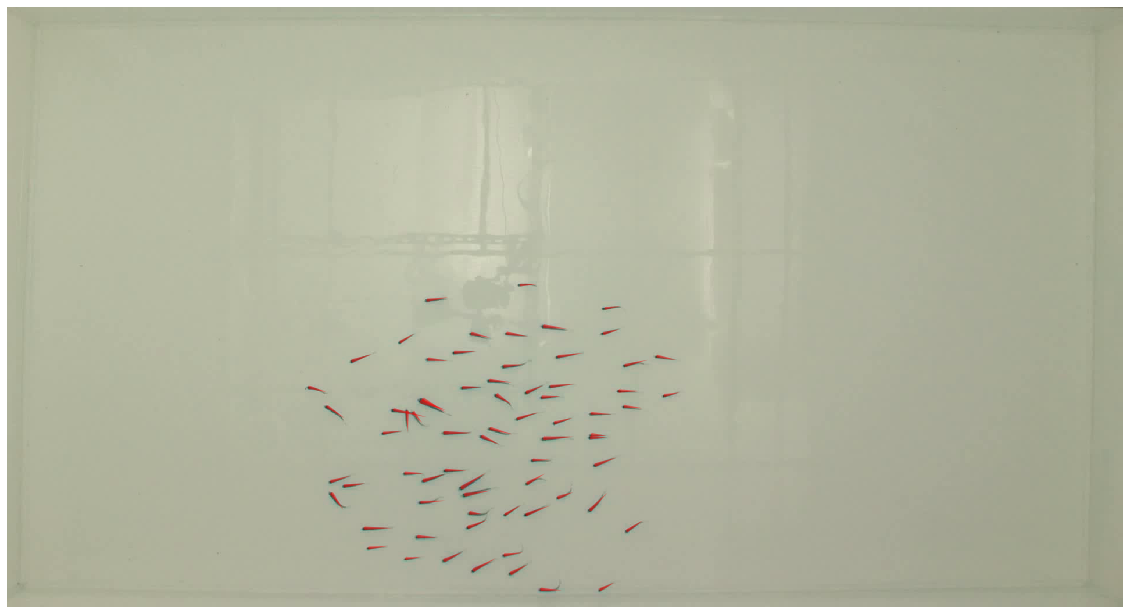

In [19]:
f,ax = plt.subplots(1,1)
f.set_size_inches(20,20)
# f.set_size_inches(40,40)
import cv2
import functions.predatorfunctions as detection
blmult=0.5

step=0
case=2
if case==0: 
    tnum=0
    trial=trials[tnum]    
    print('trial: ',trial)    
    filedir = basedir+trial 
    filedir_output = basedir_output + trial
    filenames=np.sort(glob.glob(filedir+'*fov.h5'))    
    framefile = 'savedresults/frame0_10fish.png'
    numfish=10
if case==2:
    tnum=6
    trial=trials[tnum]    
    print('trial: ',trial)    
    filedir = basedir+trial 
    filedir_output = basedir_output + trial
    filenames=np.sort(glob.glob(filedir+'*fov.h5'))    
    numfish=70
    framefile = 'savedresults/frame0_70fish.png'
    
fnum=0
filename=filenames[fnum]
print(filename)
f=hdf.File(filename,'r')
# Read in things from the file 

# positions: [step, fish_i, (x,y)]
# Note:  SHOULD CHANGE THIS TO XCENTROID, WHEN USING NEWER DATA
# This is the HEAD position for this data
single_positions = np.stack((np.transpose(f['/fields/x'].value),np.transpose(f['/fields/y'].value)),axis=-1)

# headings:  [step, fish_i]  (angle in radians)
#     single_headings = np.array(list(map(lambda x: np.arctan2(x[:,1],x[:,0]),np.stack((np.transpose(f['/fields/heading_x'].value),np.transpose(f['/fields/heading_y'].value)),axis=-1)  )))
single_heading_x = np.transpose(f['/fields/heading_x'].value)
single_heading_y = np.transpose(f['/fields/heading_y'].value)
single_orientations = np.array(list(map(lambda x: np.arctan2(x[:,1],x[:,0]),np.stack((np.transpose(f['/fields/heading_x'].value),np.transpose(f['/fields/heading_y'].value)),axis=-1)  )))
# angarea:  [step, fish_i, fish_j]
#         single_angarea = np.swapaxes(f['/fields/ang_area_left_eye'],0,1) + np.swapaxes(f['/fields/ang_area_right_eye'],0,1)  
min_angarea = np.minimum(np.swapaxes(f['/fields/ang_area_left_eye'],0,1), np.swapaxes(f['/fields/ang_area_right_eye'],0,1)  )
max_angarea = np.maximum(np.swapaxes(f['/fields/ang_area_left_eye'],0,1), np.swapaxes(f['/fields/ang_area_right_eye'],0,1)  )

single_mid_x = np.swapaxes(f['/fields/body_midline_x'].value,0,1)
single_mid_y = np.swapaxes(f['/fields/body_midline_y'].value,0,1)
single_bodylength = np.transpose(f['/fields/body_length'].value)
single_ds = np.swapaxes(f['/fields/body_midline_ds'].value,0,1)

# Switch these, to account for flip of y-axis coordinate system from normal 'image' frame to normal plotting frame.  The tracking considers the image frame, and I will plot in the 'plotting' frame, so, switch these and keep this way throughout
single_righteye = np.stack((np.transpose(f['/fields/left_eye_x'].value),np.transpose(f['/fields/left_eye_y'].value)),axis=-1)
single_lefteye = np.stack((np.transpose(f['/fields/right_eye_x'].value),np.transpose(f['/fields/right_eye_y'].value)),axis=-1)     

frameimg = cv2.imread(framefile)
points = single_positions[step]
le = single_lefteye[step]
re = single_righteye[step]
orient = single_orientations[step]
bl = single_bodylength[step] * blmult

tail_x = points[:,0]-bl*np.cos(orient)
tail_y = points[:,1]-bl*np.sin(orient)
# ax.scatter(tail_x,tail_y,color='g')
# ax.scatter(points[:,0],points[:,1],color='k')
# ax.scatter(le[:,0],le[:,1],color='b')
# ax.scatter(re[:,0],re[:,1],color='r')

fsegs = detection.fishmodel(points,le,re,np.array([tail_x,tail_y]).T)   
plotfishsegments(np.reshape(fsegs,(numfish,-1,2)),ax,clrs='r',alpha=0.5)
# ax.scatter(re[:,0],re[:,1],color='r')
# ax.scatter(le[:,0],le[:,1],color='b')
ax.imshow(frameimg,zorder=-1,origin='lower')  # NOTE THE COORDINATE SYSTEM.  This is why I flip L and R eyes above, to be consistent with normal plotting
ax.axis('off')
ax.set_aspect(1)
plt.savefig('../image-output/polygonmodel-'+str(case)+'.pdf')
# for i in range(numfish):
#     plt.plot(points[i,0]+single_mid_x[step,i],points[i,1]+single_mid_y[step,i],c='r')